In [2]:
# !pip install xlrd==1.2.0

In [3]:
import imageio
import matplotlib.pyplot as plt
import numpy             as np
import pandas            as pd
import pydotplus         as pdp
import scipy.stats       as st
import seaborn           as sns
import warnings
import datetime as dt
warnings.filterwarnings('ignore')
import scipy.stats       as stats
import statsmodels.api   as sm

from statsmodels.formula.api     import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from scipy.cluster          import hierarchy
from scipy.spatial.distance import cdist
from sklearn.cluster        import KMeans, AgglomerativeClustering
from sklearn.preprocessing  import MinMaxScaler, StandardScaler

# **ĐỌC & TIỀN XỬ LÍ DỮ LIỆU**

In [4]:
data_sales = pd.read_csv('/content/supermarket_sales.csv')
data_sales.head(10)

,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Total,Date,Time,Payment,cogs,gross margin percentage,gross income,Rating
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,1/5/2019,13:08,Ewallet,522.83,4.761905,26.1415,9.1
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,3/8/2019,10:29,Cash,76.40,4.761905,3.8200,9.6
2,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,3/3/2019,13:23,Credit card,324.31,4.761905,16.2155,7.4
3,123-19-1176,A,Yangon,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,1/27/2019,20:33,Ewallet,465.76,4.761905,23.2880,8.4
4,373-73-7910,A,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,2/8/2019,10:37,Ewallet,604.17,4.761905,30.2085,5.3
5,699-14-3026,C,Naypyitaw,Normal,Male,Electronic accessories,85.39,7,29.8865,627.6165,3/25/2019,18:30,Ewallet,597.73,4.761905,29.8865,4.1
6,355-53-5943,A,Yangon,Member,Female,Electronic accessories,68.84,6,20.6520,433.6920,2/25/2019,14:36,Ewallet,413.04,4.761905,20.6520,5.8
7,315-22-5665,C,Naypyitaw,Normal,Female,Home and lifestyle,73.56,10,36.7800,772.3800,2/24/2019,11:38,Ewallet,735.60,4.761905,36.7800,8.0
8,665-32-9167,A,Yangon,Member,Female,Health and beauty,36.26,2,3.6260,76.1460,1/10/2019,17:15,Credit card,72.52,4.761905,3.6260,7.2
9,692-92-5582,B,Mandalay,Member,Female,Food and beverages,54.84,3,8.2260,172.7460,2/20/2019,13:27,Credit card,164.52,4.761905,8.2260,5.9


In [5]:
# Check null value
data_sales.isna().sum().sort_values(ascending = False)

Invoice ID                 0
Total                      0
gross income               0
gross margin percentage    0
cogs                       0
Payment                    0
Time                       0
Date                       0
Tax 5%                     0
Branch                     0
Quantity                   0
Unit price                 0
Product line               0
Gender                     0
Customer type              0
City                       0
Rating                     0
dtype: int64

In [6]:
data_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Invoice ID               1000 non-null   object 
 1   Branch                   1000 non-null   object 
 2   City                     1000 non-null   object 
 3   Customer type            1000 non-null   object 
 4   Gender                   1000 non-null   object 
 5   Product line             1000 non-null   object 
 6   Unit price               1000 non-null   float64
 7   Quantity                 1000 non-null   int64  
 8   Tax 5%                   1000 non-null   float64
 9   Total                    1000 non-null   float64
 10  Date                     1000 non-null   object 
 11  Time                     1000 non-null   object 
 12  Payment                  1000 non-null   object 
 13  cogs                     1000 non-null   float64
 14  gross margin percentage  

In [7]:
#chuyển kiểu dữ liệu của Date từ object thành datetime
data_sales['Date'] = pd.to_datetime(data_sales['Date'], format = '%m/%d/%Y')

In [8]:
data_sales.describe()

,Unit price,Quantity,Tax 5%,Total,cogs,gross margin percentage,gross income,Rating
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.00000
mean,55.672130,5.510000,15.379369,322.966749,307.58738,4.761905,15.379369,6.97270
std,26.494628,2.923431,11.708825,245.885335,234.17651,0.000000,11.708825,1.71858
min,10.080000,1.000000,0.508500,10.678500,10.17000,4.761905,0.508500,4.00000
25%,32.875000,3.000000,5.924875,124.422375,118.49750,4.761905,5.924875,5.50000
50%,55.230000,5.000000,12.088000,253.848000,241.76000,4.761905,12.088000,7.00000
75%,77.935000,8.000000,22.445250,471.350250,448.90500,4.761905,22.445250,8.50000
max,99.960000,10.000000,49.650000,1042.650000,993.00000,4.761905,49.650000,10.00000


# **PHÂN TÍCH DỮ LIỆU & VISUALIZATION**

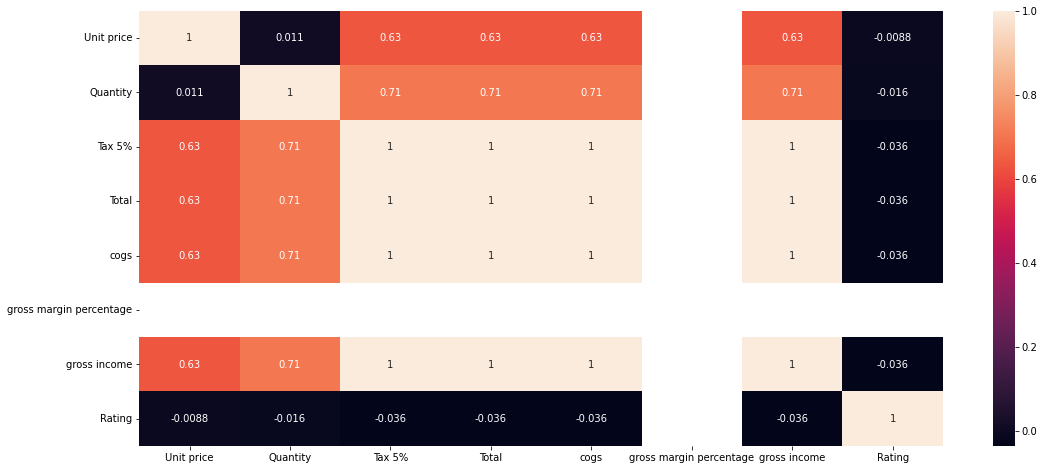

In [9]:
plt.figure(figsize = (18, 8))
sns.heatmap(data_sales.corr(), annot = True)
plt.show()

In [10]:
# Gross margin percentage không có tương quan với các dữ liệu còn lại. Nên ta sẽ loại bỏ cột Gross margin percentage
data_sales.drop(columns = ['gross margin percentage'], axis = 1, inplace=True)
data_sales.columns

Index(['Invoice ID', 'Branch', 'City', 'Customer type', 'Gender',
       'Product line', 'Unit price', 'Quantity', 'Tax 5%', 'Total', 'Date',
       'Time', 'Payment', 'cogs', 'gross income', 'Rating'],
      dtype='object')

In [11]:
# số khách hàng theo loại khách hàng và giới tính
dfgb = data_sales.groupby(by= ['Customer type','Gender'])
df_gb = dfgb.size().reset_index(name = 'Count')
print(df_gb)

  Customer type  Gender  Count
0        Member  Female    261
1        Member    Male    240
2        Normal  Female    240
3        Normal    Male    259


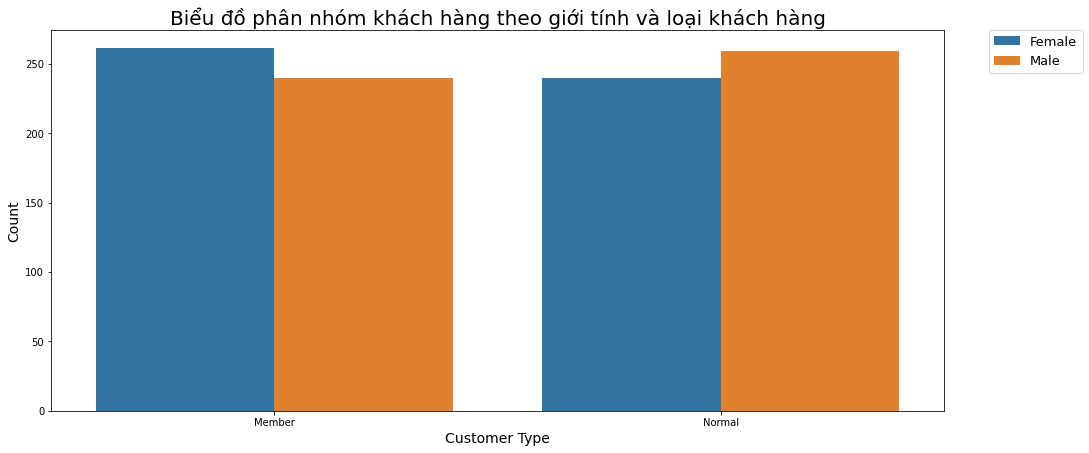

In [12]:
plt.figure(figsize = (16, 7))
sns.countplot(data = data_sales, x = 'Customer type', hue = 'Gender')
plt.title('Biểu đồ phân nhóm khách hàng theo giới tính và loại khách hàng', fontsize = 20)
plt.xlabel('Customer Type', fontsize = 14)
plt.ylabel('Count', fontsize = 14)
plt.legend(bbox_to_anchor= (1.05, 1), loc = 2, borderaxespad = 0., fontsize = 13)
plt.show()

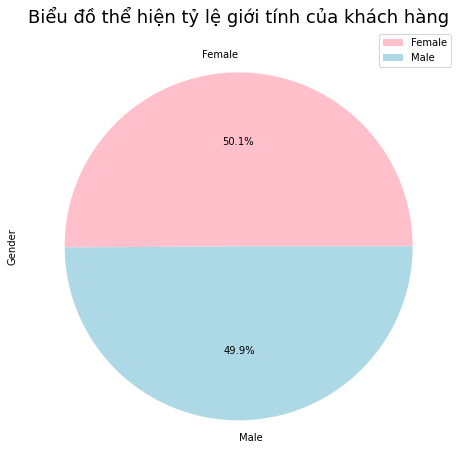

In [13]:
plt.figure(figsize=(16, 8))
data_sales["Gender"].value_counts().plot(kind="pie", colors=['pink', 'lightblue'], autopct="%1.1f%%")
plt.legend()
plt.title('Biểu đồ thể hiện tỷ lệ giới tính của khách hàng', fontsize=18)
plt.show()

In [14]:
df_gb = data_sales.groupby(by = ['Customer type','Gender'])['Total','Rating'].mean()
print(df_gb)

                           Total    Rating
Customer type Gender                      
Member        Female  337.727753  6.940613
              Male    316.985419  6.940000
Normal        Female  332.233256  6.990417
              Male    305.047581  7.018919


In [15]:
#đánh giá mức độ hài lòng của khách hàng khi mua sắm dựa trên điểm Rating
def rating_levels (rate):
  if rate >= 8:
    return 'Rất hài lòng'
  elif rate >= 6:
    return 'Hài lòng'
  else:
    return 'Chưa hài lòng'

data_rating = data_sales.copy()
data_rating['Satisfaction Level'] = data_rating['Rating'].apply(rating_levels)

<Figure size 1152x576 with 0 Axes>

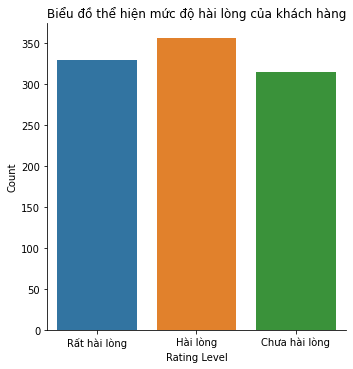

In [16]:
#biểu đồ thể hiện mức độ hài lòng của khách hàng
plt.figure(figsize = (16, 8))
sns.catplot(kind = 'count', data = data_rating, x = 'Satisfaction Level')
plt.title('Biểu đồ thể hiện mức độ hài lòng của khách hàng')
plt.xlabel('Rating Level', fontsize = 10)
plt.ylabel('Count', fontsize = 10)
plt.show()

<Figure size 2160x1440 with 0 Axes>

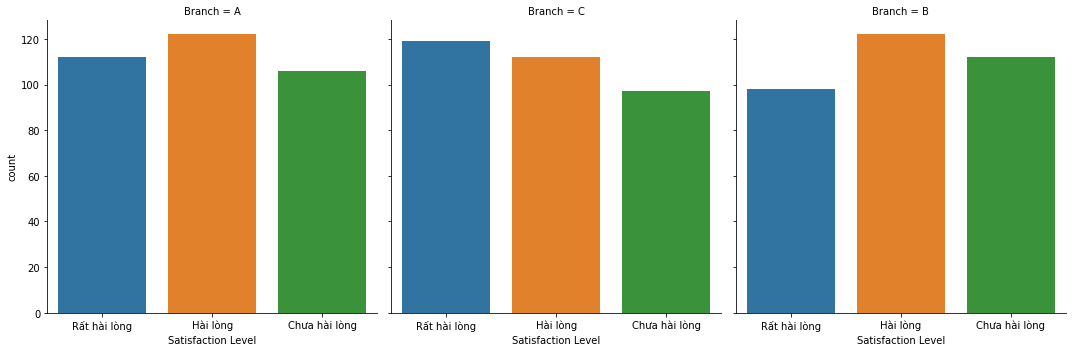

In [17]:
plt.figure(figsize = (30, 20))
sns.catplot(kind = 'count', data = data_rating, x = 'Satisfaction Level', col = 'Branch')
plt.xlabel('Satisfaction Level', fontsize = 10)
plt.ylabel('Count', fontsize = 10)

plt.show()

In [18]:
df_gb = data_sales.groupby(by = ['Product line']).agg({'Quantity':['count','min','max','var']})
print(df_gb)

                       Quantity                  
                          count min max       var
Product line                                     
Electronic accessories      170   1  10  8.466725
Fashion accessories         178   1  10  9.622548
Food and beverages          174   1  10  8.250615
Health and beauty           152   1  10  8.105089
Home and lifestyle          160   1  10  7.962225
Sports and travel           166   1  10  8.710332


In [19]:
#tách ngày, tháng, năm ra thành từng cột để phân tích doanh thu theo từng tháng
data_rating['Day'] = data_rating['Date'].dt.day
data_rating['Month'] = data_rating['Date'].dt.month
data_rating['Year'] = data_rating['Date'].dt.year

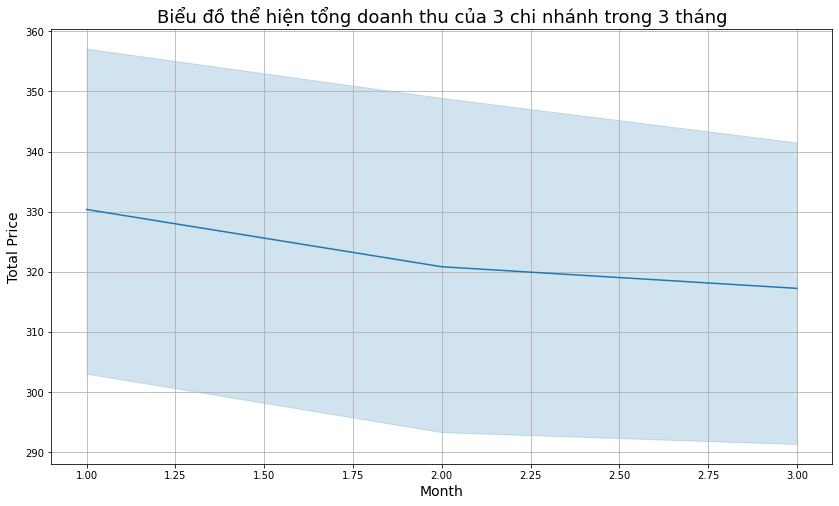

In [20]:
plt.figure(figsize=(14,8))
ax = sns.lineplot(data = data_rating, x="Month", y="Total")
plt.title('Biểu đồ thể hiện tổng doanh thu của 3 chi nhánh trong 3 tháng', fontsize = 18)
ax.set_xlabel('Month', fontsize = 14)
ax.set_ylabel('Total Price', fontsize = 14)
plt.grid()
plt.show()

In [21]:
monthsale_city = data_rating.pivot_table(values = ['Total'], columns = ['City'], index = ['Month'], aggfunc='mean')

In [22]:
monthsale_city

Total                        
City     Mandalay   Naypyitaw      Yangon
Month                                    
1      334.919446  331.431811  325.051500
2      315.819000  329.349825  317.660856
3      308.904844  350.934368  296.528516

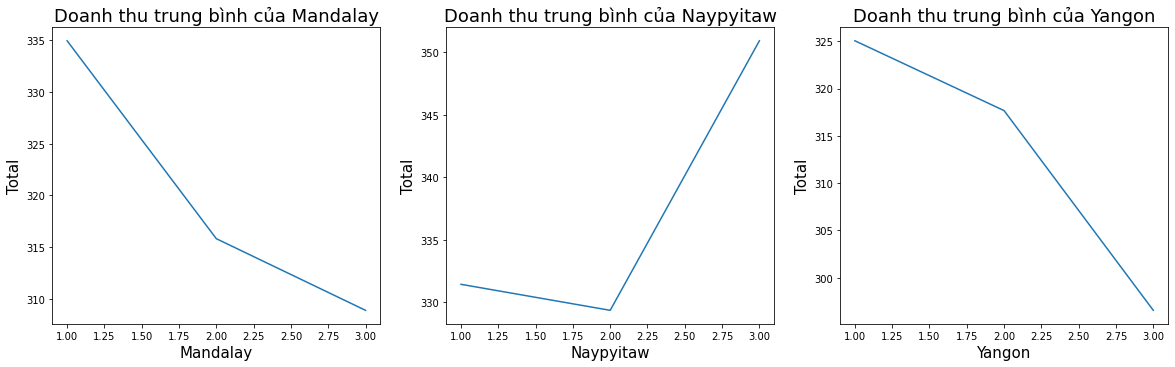

In [45]:
plt.figure(figsize = (20,12))

x = [1, 2, 3]

plt.subplot(2,3,1)
sns.lineplot(data=monthsale_city['Total','Mandalay'])
plt.title('Doanh thu trung bình của Mandalay', fontsize = 18)
plt.xlabel('Mandalay', fontsize = 15)
plt.ylabel('Total', fontsize = 15)

plt.subplot(2,3,2)
sns.lineplot(data=monthsale_city['Total','Naypyitaw']) 
plt.title('Doanh thu trung bình của Naypyitaw', fontsize = 18)
plt.xlabel('Naypyitaw', fontsize = 15)
plt.ylabel('Total', fontsize = 15)

plt.subplot(2,3,3)
sns.lineplot(data=monthsale_city['Total','Yangon'])
plt.title('Doanh thu trung bình của Yangon', fontsize = 18)
plt.xlabel('Yangon', fontsize = 15)
plt.ylabel('Total', fontsize = 15)

plt.show()

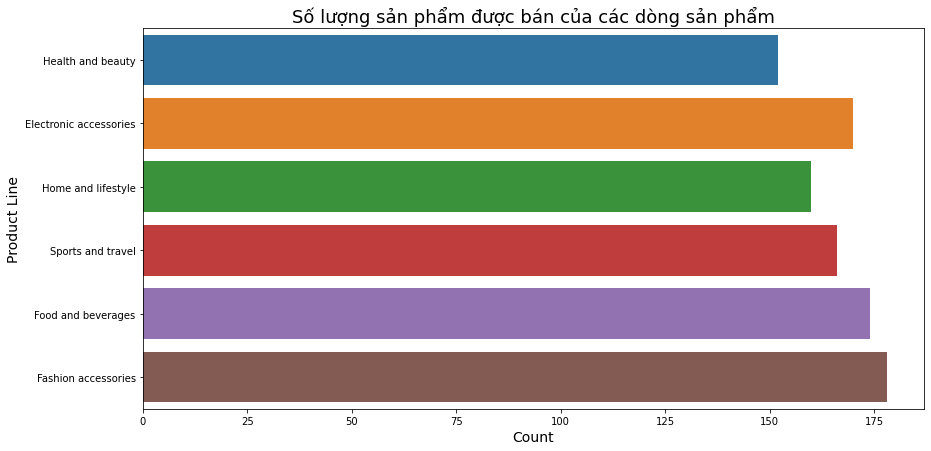

In [46]:
plt.figure(figsize=(14, 7))
plt.title('Số lượng sản phẩm được bán của các dòng sản phẩm', size = 18)
sns.countplot(y = 'Product line', data = data_sales)
plt.xlabel('Count', fontsize = 14)
plt.ylabel('Product Line', fontsize = 14)
plt.show()

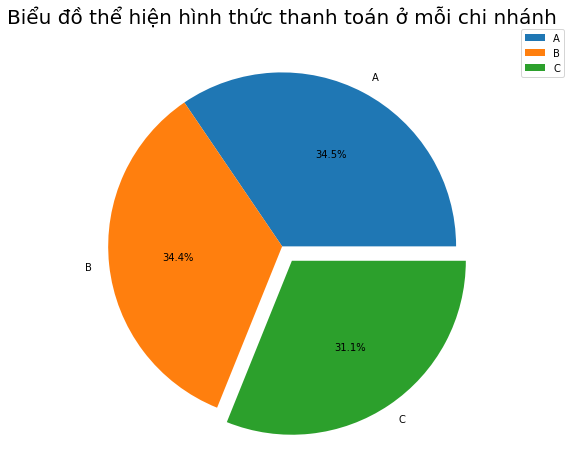

In [47]:
plt.figure(figsize = (14, 8))
plt.pie(x = data_sales['Payment'].value_counts().values, 
        labels = list(data_sales['Branch'].value_counts().keys()), 
        autopct='%1.1f%%', shadow=False, explode=[0,0,0.1])
plt.title('Biểu đồ thể hiện hình thức thanh toán ở mỗi chi nhánh', size = 20)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

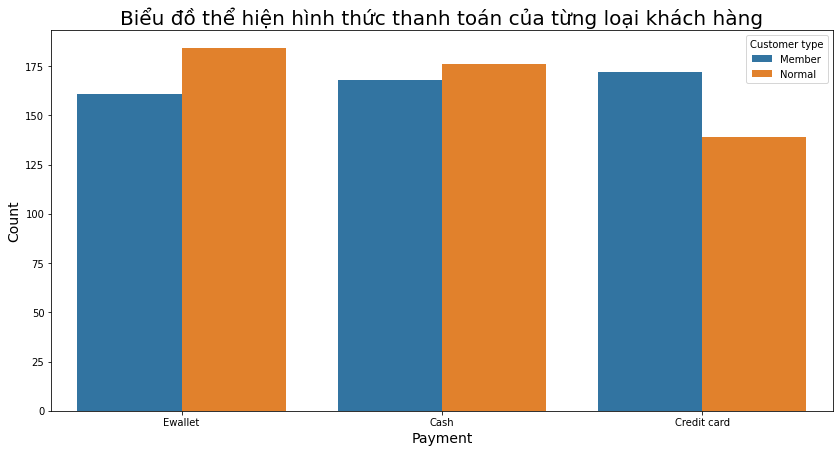

In [48]:
plt.figure(figsize = (14,7))
sns.countplot(data = data_sales, x = 'Payment', hue = 'Customer type')
plt.title('Biểu đồ thể hiện hình thức thanh toán của từng loại khách hàng', fontsize = 20)
plt.xlabel('Payment', fontsize = 14)
plt.ylabel('Count', fontsize = 14)
plt.show()

In [49]:
data_rating.head()

,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Total,Date,Time,Payment,cogs,gross income,Rating,Satisfaction Level,Day,Month,Year
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,2019-01-05,13:08,Ewallet,522.83,26.1415,9.1,Rất hài lòng,5,1,2019
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,2019-03-08,10:29,Cash,76.40,3.8200,9.6,Rất hài lòng,8,3,2019
2,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,2019-03-03,13:23,Credit card,324.31,16.2155,7.4,Hài lòng,3,3,2019
3,123-19-1176,A,Yangon,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,2019-01-27,20:33,Ewallet,465.76,23.2880,8.4,Rất hài lòng,27,1,2019
4,373-73-7910,A,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,2019-02-08,10:37,Ewallet,604.17,30.2085,5.3,Chưa hài lòng,8,2,2019


In [50]:
#biểu đồ thể hiện tỷ lệ mức độ hài lòng của khách hàng mua hàng theo các thuộc tính: Gender, Branch và Customer type
br = data_rating[['Gender', 'Customer type', 'Branch', 'Satisfaction Level']]
br.head()

,Gender,Customer type,Branch,Satisfaction Level
0,Female,Member,A,Rất hài lòng
1,Female,Normal,C,Rất hài lòng
2,Male,Normal,A,Hài lòng
3,Male,Member,A,Rất hài lòng
4,Male,Normal,A,Chưa hài lòng


In [51]:
#biểu đồ thể hiện tỷ lệ mức độ hài lòng của khách hàng mua hàng theo các thuộc tính: Gender, Branch và Customer type
import plotly.express as px
fig = px.parallel_categories(br)
fig.show()

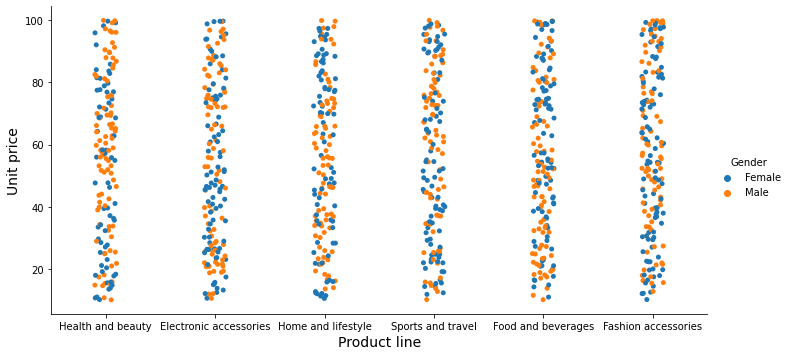

In [52]:
#biểu đồ thể hiện mối tương quan giữa dòng sản phẩm và giá cả theo giới tính
sns.catplot(x = 'Product line', y = 'Unit price', hue = 'Gender', data = data_sales, aspect=2)
plt.xlabel('Product line', fontsize = 14)
plt.ylabel('Unit price', fontsize = 14)
plt.show()

# **PHÂN TÍCH THEO MÔ HÌNH RFM**

In [53]:
id_lst = []
for i in data_sales.values:
  if i[4] == 'Female':
    if i[3] == 'Member':
      id = np.random.randint(1,50)
    else:
      id = np.random.randint(50,100)
  else:
    if i[3] == 'Member':
      id = np.random.randint(100,150)
    else:
      id = np.random.randint(150,201)
  id_lst.append(id)
print(id_lst)

[17, 56, 167, 107, 197, 154, 2, 68, 43, 25, 47, 128, 93, 193, 56, 11, 5, 179, 190, 88, 103, 161, 196, 157, 115, 40, 150, 61, 89, 167, 169, 107, 197, 200, 33, 29, 130, 85, 56, 131, 41, 102, 2, 7, 139, 47, 136, 29, 109, 11, 133, 34, 1, 140, 170, 69, 111, 186, 47, 198, 25, 188, 33, 109, 110, 113, 84, 30, 162, 3, 151, 187, 10, 68, 169, 91, 106, 12, 45, 53, 62, 52, 197, 20, 104, 97, 155, 110, 154, 52, 24, 70, 31, 120, 190, 175, 168, 82, 164, 167, 104, 189, 94, 191, 176, 142, 199, 176, 89, 100, 49, 37, 51, 146, 10, 55, 146, 105, 89, 198, 53, 109, 136, 132, 16, 55, 55, 79, 2, 69, 58, 13, 87, 141, 67, 159, 72, 32, 195, 167, 17, 102, 24, 7, 91, 93, 32, 160, 104, 181, 46, 119, 184, 54, 59, 140, 104, 172, 105, 173, 68, 187, 166, 191, 163, 137, 197, 171, 153, 123, 177, 110, 188, 140, 193, 110, 123, 77, 183, 117, 167, 139, 130, 150, 98, 105, 41, 118, 170, 64, 78, 58, 86, 178, 170, 15, 128, 50, 161, 7, 37, 1, 160, 108, 147, 56, 43, 9, 68, 57, 182, 66, 185, 190, 37, 168, 78, 43, 166, 83, 188, 191, 18

In [54]:
new_df = pd.concat([data_sales,pd.DataFrame(id_lst)],axis =1)
new_df.head()

,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Total,Date,Time,Payment,cogs,gross income,Rating,0
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,2019-01-05,13:08,Ewallet,522.83,26.1415,9.1,17
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,2019-03-08,10:29,Cash,76.40,3.8200,9.6,56
2,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,2019-03-03,13:23,Credit card,324.31,16.2155,7.4,167
3,123-19-1176,A,Yangon,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,2019-01-27,20:33,Ewallet,465.76,23.2880,8.4,107
4,373-73-7910,A,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,2019-02-08,10:37,Ewallet,604.17,30.2085,5.3,197


In [55]:
new_df.rename(columns = {0:'Customer ID'}, inplace=True)
new_df.head()

,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Total,Date,Time,Payment,cogs,gross income,Rating,Customer ID
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,2019-01-05,13:08,Ewallet,522.83,26.1415,9.1,17
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,2019-03-08,10:29,Cash,76.40,3.8200,9.6,56
2,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,2019-03-03,13:23,Credit card,324.31,16.2155,7.4,167
3,123-19-1176,A,Yangon,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,2019-01-27,20:33,Ewallet,465.76,23.2880,8.4,107
4,373-73-7910,A,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,2019-02-08,10:37,Ewallet,604.17,30.2085,5.3,197


In [56]:
# Lấy ngày lớn nhất cộng 1
current_date = max(new_df['Date']) + dt.timedelta(days = 1)

# Groupby Customer ID để tính RFM
df_customers = new_df.groupby(['Customer ID']).agg(
    {
        'Date': lambda x: (current_date - x.max()).days,
        'Invoice ID': 'count',
        'Total': 'sum'
    }
)

In [57]:
df_customers.rename(columns = {'Date': 'Recency', 'Invoice ID': 'Frequency', 'Total': 'Monetary'}, inplace = True)

df_customers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199 entries, 1 to 200
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Recency    199 non-null    int64  
 1   Frequency  199 non-null    int64  
 2   Monetary   199 non-null    float64
dtypes: float64(1), int64(2)
memory usage: 6.2 KB


In [58]:
df_customers.head()

,Recency,Frequency,Monetary
Customer ID,,,
1,9,5,1648.9830
2,32,7,3082.5375
3,26,6,2060.1840
4,11,5,1145.8860
5,4,7,2522.9925


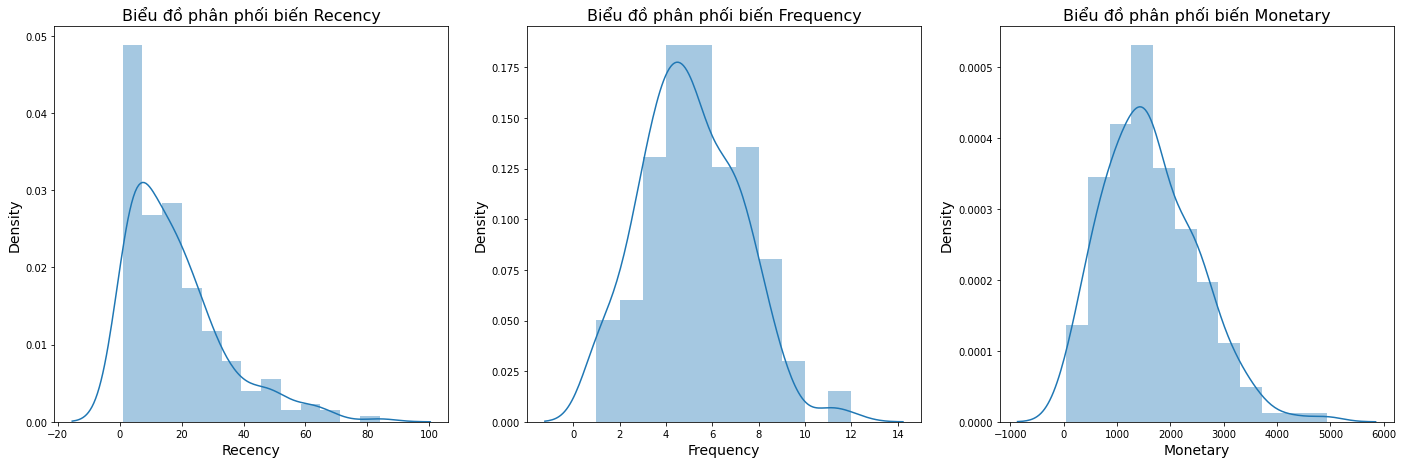

In [59]:
# Vẽ phân phối 3 biến RFM
plt.figure(figsize = (24,16))

plt.subplot(2,3,1)
sns.distplot(df_customers['Recency'])
plt.title('Biểu đồ phân phối biến Recency', fontsize = 16)
plt.xlabel('Recency', fontsize = 14)
plt.ylabel('Density', fontsize = 14)

plt.subplot(2,3,2)
sns.distplot(df_customers['Frequency'])
plt.title('Biểu đồ phân phối biến Frequency', fontsize = 16)
plt.xlabel('Frequency', fontsize = 14)
plt.ylabel('Density', fontsize = 14)

plt.subplot(2,3,3)
sns.distplot(df_customers['Monetary'])
plt.title('Biểu đồ phân phối biến Monetary', fontsize = 16)
plt.xlabel('Monetary', fontsize = 14)
plt.ylabel('Density', fontsize = 14)

plt.show()

In [60]:
from scipy import stats
def analyze_skewness(x):
    fig, ax = plt.subplots(2, 2, figsize=(12,8))
    sns.distplot(df_customers[x], ax=ax[0,0])
    sns.distplot(np.log(df_customers[x]), ax=ax[0,1])
    sns.distplot(np.sqrt(df_customers[x]), ax=ax[1,0])
    sns.distplot(stats.boxcox(df_customers[x])[0], ax=ax[1,1])
    plt.tight_layout()
    plt.show()
    
    print(df_customers[x].skew().round(2))
    print(np.log(df_customers[x]).skew().round(2))
    print(np.sqrt(df_customers[x]).skew().round(2))
    print(pd.Series(stats.boxcox(df_customers[x])[0]).skew().round(2))

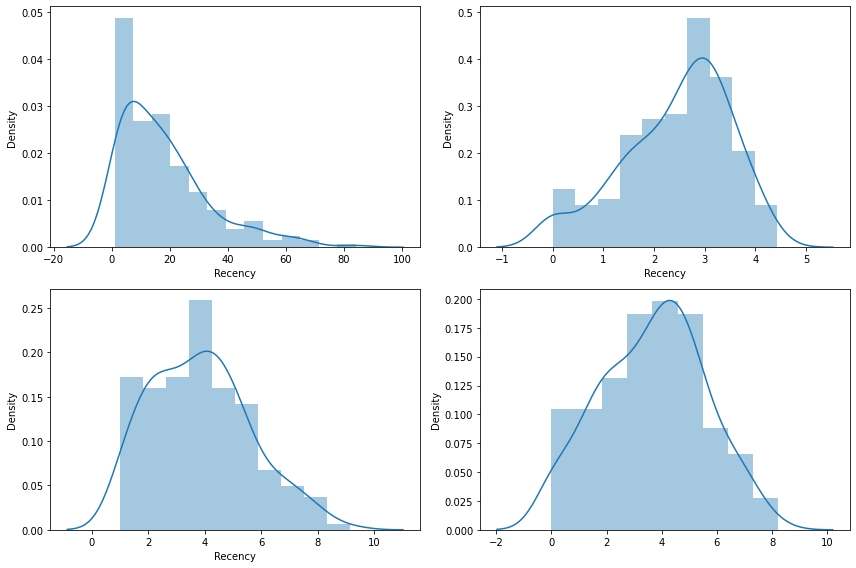

1.41
-0.61
0.44
-0.06


In [61]:
analyze_skewness('Recency')

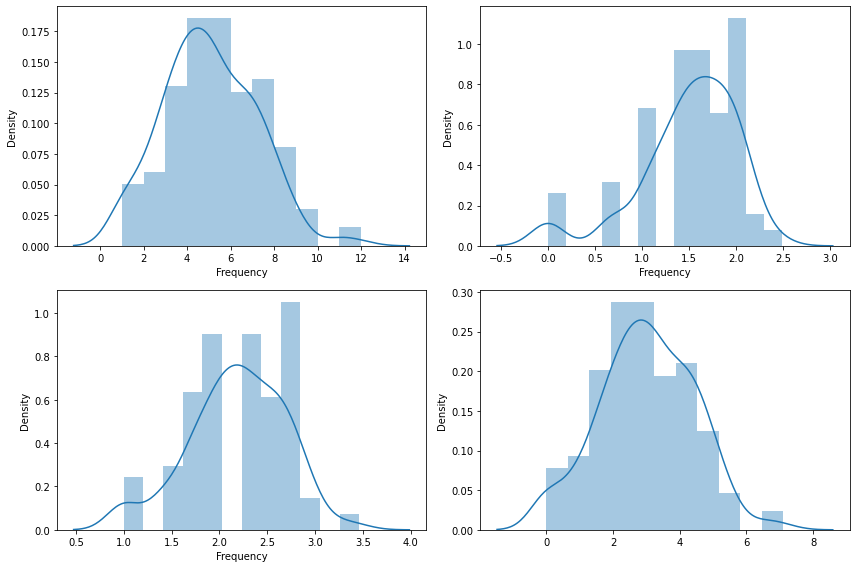

0.29
-1.13
-0.37
-0.04


In [62]:
analyze_skewness('Frequency')

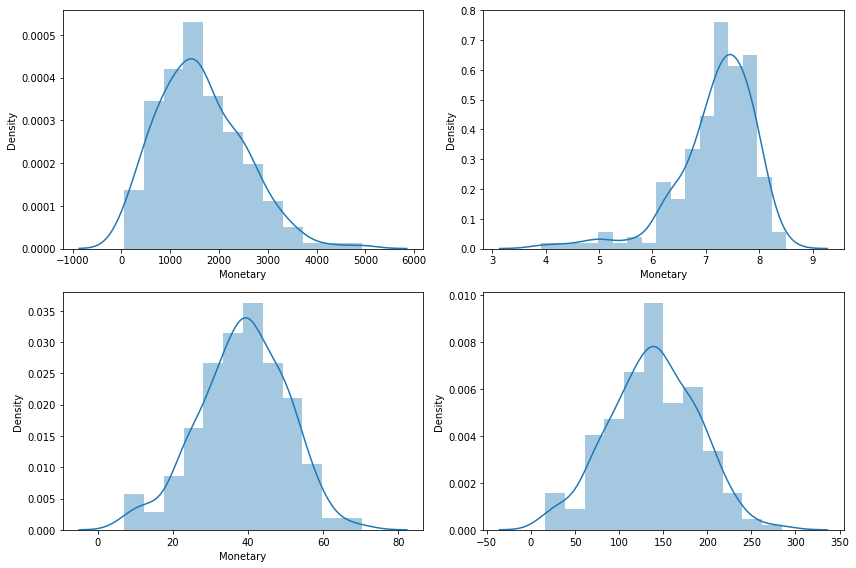

0.61
-1.58
-0.25
-0.05


In [63]:
analyze_skewness('Monetary')

In [64]:
#tiến hành transform 
df_customer_tf = pd.DataFrame()
df_customer_tf['Recency'] = stats.boxcox(df_customers['Recency'])[0]
df_customer_tf['Frequency'] = stats.boxcox(df_customers['Frequency'])[0]
df_customer_tf['Monetary'] = stats.boxcox(df_customers['Monetary'])[0]
df_customer_tf.head(10)

,Recency,Frequency,Monetary
0,2.947921,3.085587,145.606429
1,5.575148,4.335591,213.537968
2,5.084756,3.724366,166.890096
3,3.308971,3.085587,116.442943
4,1.663667,4.335591,188.926390
5,0.000000,4.335591,186.661154
6,4.158866,4.335591,208.448407
7,5.723306,2.412011,160.618420
8,1.990940,4.335591,229.928345
9,5.084756,1.692053,125.206479


In [65]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df_customer_tf)

df_customer_tf = scaler.transform(df_customer_tf)

In [66]:
pd.DataFrame(df_customer_tf).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199 entries, 0 to 198
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       199 non-null    float64
 1   1       199 non-null    float64
 2   2       199 non-null    float64
dtypes: float64(3)
memory usage: 4.8 KB


In [67]:
#tạo 1 bản copy của df_customers để tính điểm theo mô hình RFM
dfc_copy = df_customers.copy()
#tính điểm rfm
dfc_copy["recency_score"] = pd.qcut(dfc_copy['Recency'], 5, labels = [5, 4, 3, 2, 1])
dfc_copy["frequency_score"] = pd.qcut(dfc_copy['Frequency'].rank(method = "first"), 5, labels = [1, 2, 3, 4, 5])
dfc_copy["monetary_score"] = pd.qcut(dfc_copy['Monetary'], 5, labels = [1, 2, 3, 4, 5])
dfc_copy['score'] = dfc_copy['recency_score'].astype(int) + dfc_copy['frequency_score'].astype(int) + dfc_copy['monetary_score'].astype(int)

In [68]:
def rfm_scores_ranking(score):
  if ((score) >= 1 and (score < 4)):
    return 'Khách hàng ít tiềm năng'
  elif ((score >= 4) and (score < 7)):
    return 'Khách hàng thông thường'
  elif ((score >= 7) and (score < 11)):
    return 'Khách hàng tiềm năng'
  else:
    return 'Khách hàng V.I.P'

In [69]:
dfc_copy['Customer Type'] = dfc_copy['score'].apply(lambda score : rfm_scores_ranking(score))
dfc_copy.head()

,Recency,Frequency,Monetary,recency_score,frequency_score,monetary_score,score,Customer Type
Customer ID,,,,,,,,
1,9,5,1648.9830,4,3,3,10,Khách hàng tiềm năng
2,32,7,3082.5375,1,4,5,10,Khách hàng tiềm năng
3,26,6,2060.1840,2,4,4,10,Khách hàng tiềm năng
4,11,5,1145.8860,4,3,2,9,Khách hàng tiềm năng
5,4,7,2522.9925,5,4,5,14,Khách hàng V.I.P


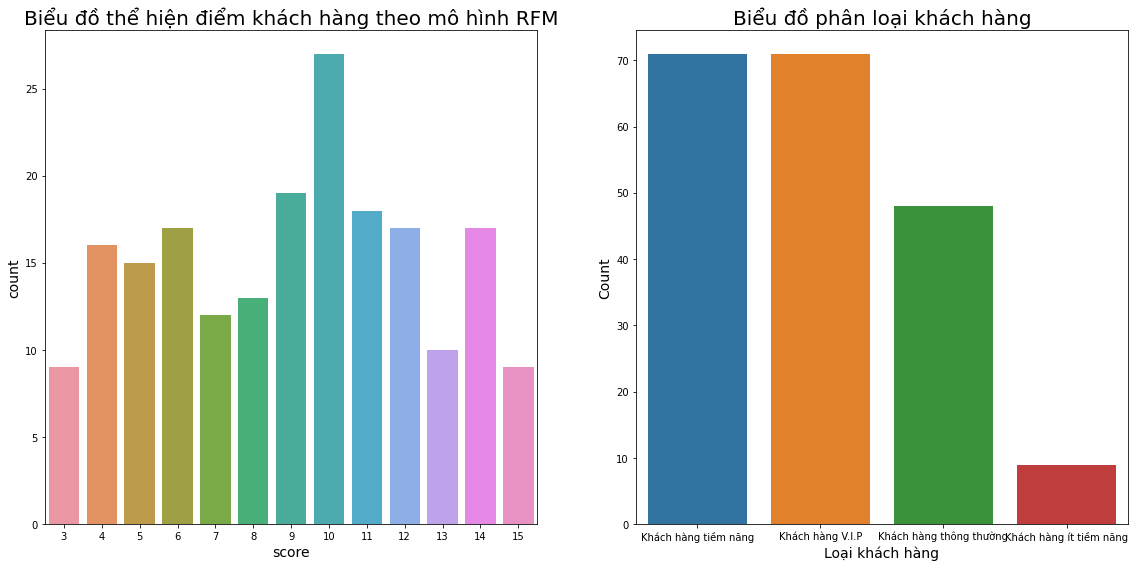

In [74]:
plt.figure(figsize = (30,20))

plt.subplot(2,3,1)
plt.title('Biểu đồ thể hiện điểm khách hàng theo mô hình RFM', fontsize = 20)
plt.xlabel('Điểm RFM', fontsize = 14)
plt.ylabel('Count', fontsize = 14)
sns.countplot(data=dfc_copy,x="score")

plt.subplot(2,3,2)
plt.title('Biểu đồ phân loại khách hàng', fontsize = 20)
sns.countplot(data=dfc_copy,x='Customer Type')
plt.xlabel('Loại khách hàng', fontsize = 14)
plt.ylabel('Count', fontsize = 14)

plt.show()

In [75]:
dfc_copy.reset_index(inplace = True)
cols = ['Customer ID', 'recency_score',	'frequency_score',	'monetary_score']
dfc_copy.drop(columns = cols, inplace = True)
dfc_copy.head()

,Recency,Frequency,Monetary,score,Customer Type
0,9,5,1648.9830,10,Khách hàng tiềm năng
1,32,7,3082.5375,10,Khách hàng tiềm năng
2,26,6,2060.1840,10,Khách hàng tiềm năng
3,11,5,1145.8860,9,Khách hàng tiềm năng
4,4,7,2522.9925,14,Khách hàng V.I.P


# **K means**

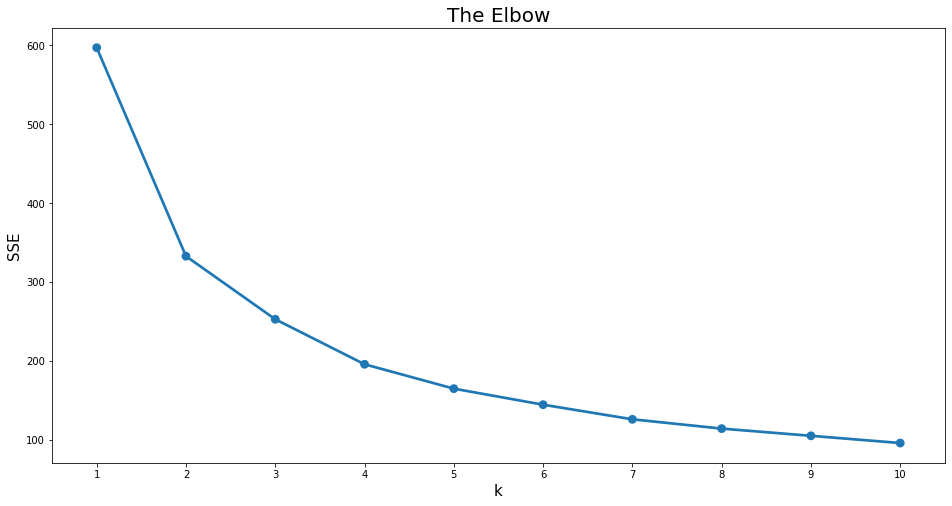

In [76]:
# Chọn số cụm k bằng Elbow
from sklearn.cluster import KMeans

sse = {}
for k in range(1, 11):
  kmeans = KMeans(n_clusters = k, random_state=42)
  kmeans.fit(df_customer_tf)
  sse[k] = kmeans.inertia_

plt.figure(figsize = (16,8))
plt.title('The Elbow', fontsize = 20)
plt.xlabel('k', fontsize = 15)
plt.ylabel('SSE', fontsize = 15)
sns.pointplot(x=list(sse.keys()), y = list(sse.values()))
plt.show()

In [77]:
model = KMeans(n_clusters=4, random_state=42)
model.fit(df_customer_tf)

df_customers['Cluster'] = model.labels_
df_customers.head()

,Recency,Frequency,Monetary,Cluster
Customer ID,,,,
1,9,5,1648.9830,3
2,32,7,3082.5375,2
3,26,6,2060.1840,2
4,11,5,1145.8860,3
5,4,7,2522.9925,0


In [78]:
df_customers.groupby('Cluster').agg(
    {
        'Recency':'mean',
        'Frequency':'mean',
        'Monetary':'mean'
    }
).round(2)

,Recency,Frequency,Monetary
Cluster,,,
0,7.32,7.95,2810.40
1,33.49,2.70,753.29
2,21.00,5.52,1873.29
3,4.76,4.60,1294.00


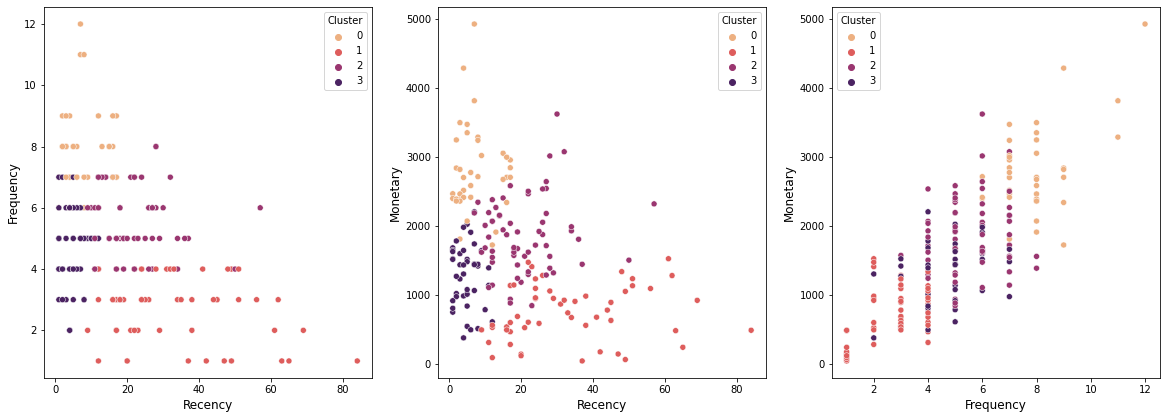

In [79]:
plt.figure(figsize = (20, 15))


plt.subplot(2, 3, 1)
sns.scatterplot(data = df_customers, x = df_customers['Recency'], y = df_customers['Frequency'], hue = df_customers['Cluster'], palette = "flare")
plt.xlabel('Recency', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)

plt.subplot(2, 3, 2)
sns.scatterplot(data = df_customers, x = df_customers['Recency'], y = df_customers['Monetary'], hue = df_customers['Cluster'], palette = "flare")
plt.xlabel('Recency', fontsize = 12)
plt.ylabel('Monetary', fontsize = 12)

plt.subplot(2, 3, 3)
sns.scatterplot(data = df_customers, x = df_customers['Frequency'], y = df_customers['Monetary'], hue = df_customers['Cluster'], palette = "flare")
plt.xlabel('Frequency', fontsize = 12)
plt.ylabel('Monetary', fontsize = 12)

plt.show()

# **HAC**


In [80]:
##------------------------------------------------------------------------------
##------------------------------------------------------------------------------
data_x = data_sales.copy()
drop_columns = ['Invoice ID', 'City', 'Product line', 'Unit price', 'Tax 5%', 'Quantity', 'Date', 'Time', 'cogs', 'gross income']
data = data_x.drop(columns = drop_columns)

In [81]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Branch         1000 non-null   object 
 1   Customer type  1000 non-null   object 
 2   Gender         1000 non-null   object 
 3   Total          1000 non-null   float64
 4   Payment        1000 non-null   object 
 5   Rating         1000 non-null   float64
dtypes: float64(2), object(4)
memory usage: 47.0+ KB


In [82]:
##------------------------------------------------------------------------------
## Chuyển dữ liệu CATEGORICAL --> NUMERICAL 
data = pd.get_dummies(data)
print(data.head())

      Total  Rating  Branch_A  Branch_B  Branch_C  Customer type_Member  \
0  548.9715     9.1         1         0         0                     1   
1   80.2200     9.6         0         0         1                     0   
2  340.5255     7.4         1         0         0                     0   
3  489.0480     8.4         1         0         0                     1   
4  634.3785     5.3         1         0         0                     0   

   Customer type_Normal  Gender_Female  Gender_Male  Payment_Cash  \
0                     0              1            0             0   
1                     1              1            0             1   
2                     1              0            1             0   
3                     0              0            1             0   
4                     1              0            1             0   

   Payment_Credit card  Payment_Ewallet  
0                    0                1  
1                    0                0  
2       

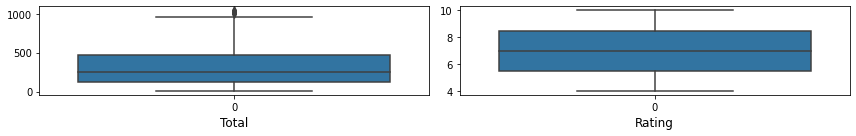

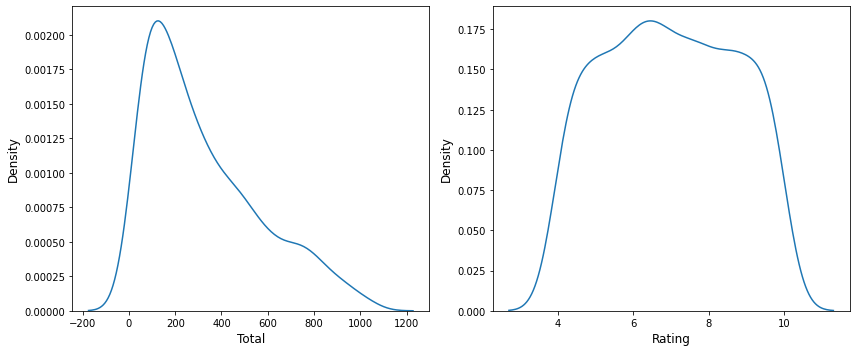

In [83]:
##------------------------------------------------------------------------------
## Kiểm tra outlier(s) dựa trên boxplot đối với các biến LIÊN TỤC
##    --> chọn phương pháp chuẩn hóa dữ liệu
plt.figure(figsize = (12, 2))

plt.subplot(1, 2, 1)
sns.boxplot(data.Total)
plt.xlabel('Total', fontsize = 12)

plt.subplot(1, 2, 2)
sns.boxplot(data.Rating)
plt.xlabel('Rating', fontsize = 12)

plt.tight_layout()
plt.show()

##------------------------------------------------------------------------------
## Kiểm tra các biến LIÊN TỤC có phải phân phối chuẩn
##------------------------------------------------------------------------------
plt.figure(figsize = (12, 5))

plt.subplot(1, 2, 1)
sns.distplot(data.Total, hist = False)
plt.xlabel('Total', fontsize = 12)
plt.ylabel('Density', fontsize = 12)

plt.subplot(1, 2, 2)
sns.distplot(data.Rating, hist = False)
plt.xlabel('Rating', fontsize = 12)
plt.ylabel('Density', fontsize = 12)

plt.tight_layout()
plt.show()

## Các features 'Total' và 'Rating' không có phân phối chuẩn. Features 'Rating' không có outliers, 'Total' có outliers
##    --> loại bỏ outliers

In [84]:
# IQR
Q1 = np.percentile(data.Total, 25, interpolation = 'midpoint')
Q3 = np.percentile(data.Total, 75, interpolation = 'midpoint')
IQR = Q3 - Q1
upper = Q3 + 1.5 * IQR
lower = Q1 - 1.5 * IQR
outliers = []
# Upper bound
upper = np.where(data.Total > upper)
# Lower bound
lower = np.where(data.Total < lower)

#xóa outliers
data.drop(upper[0], inplace = True)
data.drop(lower[0], inplace = True)

data.reset_index(inplace=True)

In [85]:
from sklearn.preprocessing import MinMaxScaler
##------------------------------------------------------------------------------
## Chuẩn hóa dữ liệu LIÊN TỤC: MinMaxScaler
##------------------------------------------------------------------------------
scaler    = MinMaxScaler()
data_norm = pd.DataFrame(scaler.fit_transform(data[['Total', 'Rating']]),
                         columns = ['total_norm', 'rating_norm'])

data_norm = pd.concat([data_norm, data], axis = 1, ignore_index = False)
print(data_norm.head())

   total_norm  rating_norm  index     Total  Rating  Branch_A  Branch_B  \
0    0.571955     0.850000      0  548.9715     9.1         1         0   
1    0.073890     0.933333      1   80.2200     9.6         0         0   
2    0.350474     0.566667      2  340.5255     7.4         1         0   
3    0.508284     0.733333      3  489.0480     8.4         1         0   
4    0.662702     0.216667      4  634.3785     5.3         1         0   

   Branch_C  Customer type_Member  Customer type_Normal  Gender_Female  \
0         0                     1                     0              1   
1         1                     0                     1              1   
2         0                     0                     1              0   
3         0                     1                     0              0   
4         0                     0                     1              0   

   Gender_Male  Payment_Cash  Payment_Credit card  Payment_Ewallet  
0            0             0       

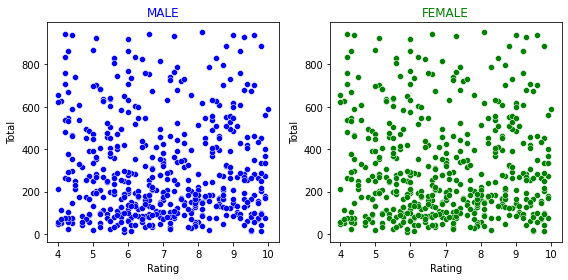

In [86]:
##------------------------------------------------------------------------------
## Biểu diễn trực quan dữ liệu: Rating - Total
##------------------------------------------------------------------------------
data_M = data_norm.where(data_norm['Gender_Male'] == 1).dropna()
data_F = data_norm.where(data_norm['Gender_Female'] == 0).dropna()

plt.figure(figsize = (8, 4))
plt.subplot(1, 2, 1)
sns.scatterplot(data = data_M, x = 'Rating', y = 'Total', color = 'b')
plt.title('MALE', color = 'b')

plt.subplot(1, 2, 2)
sns.scatterplot(data = data_F, x = 'Rating', y = 'Total', color = 'g')
plt.title('FEMALE', color = 'g')

plt.tight_layout()
plt.show()

##### *2.2 Gom cụm bằng thuật toán HAC*

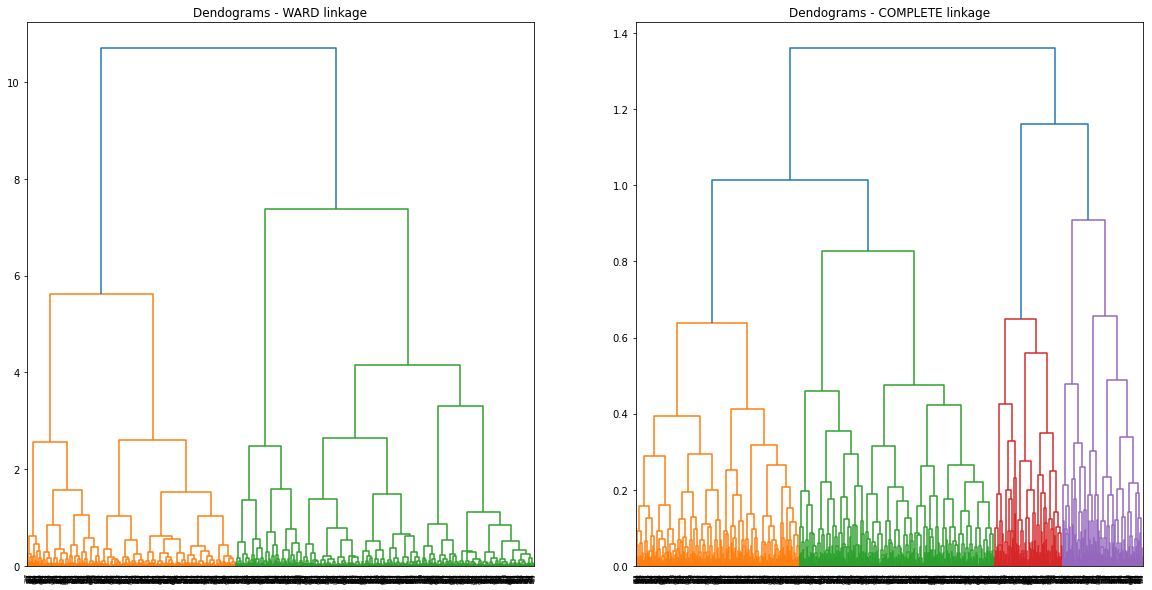

In [87]:
##------------------------------------------------------------------------------
## Vẽ dendrogram
##------------------------------------------------------------------------------
from scipy.cluster import hierarchy

plt.figure(figsize = (20, 10))

plt.subplot(1,2,1)
plt.title("Dendograms - WARD linkage")
linkage = hierarchy.linkage(data_norm[['rating_norm', 'total_norm']], method = 'ward')
dendrogram = hierarchy.dendrogram(linkage)

plt.subplot(1,2,2)
plt.title("Dendograms - COMPLETE linkage")
linkage = hierarchy.linkage(data_norm[['rating_norm', 'total_norm']], method = 'complete')
dendrogram = hierarchy.dendrogram(linkage)

plt.show()

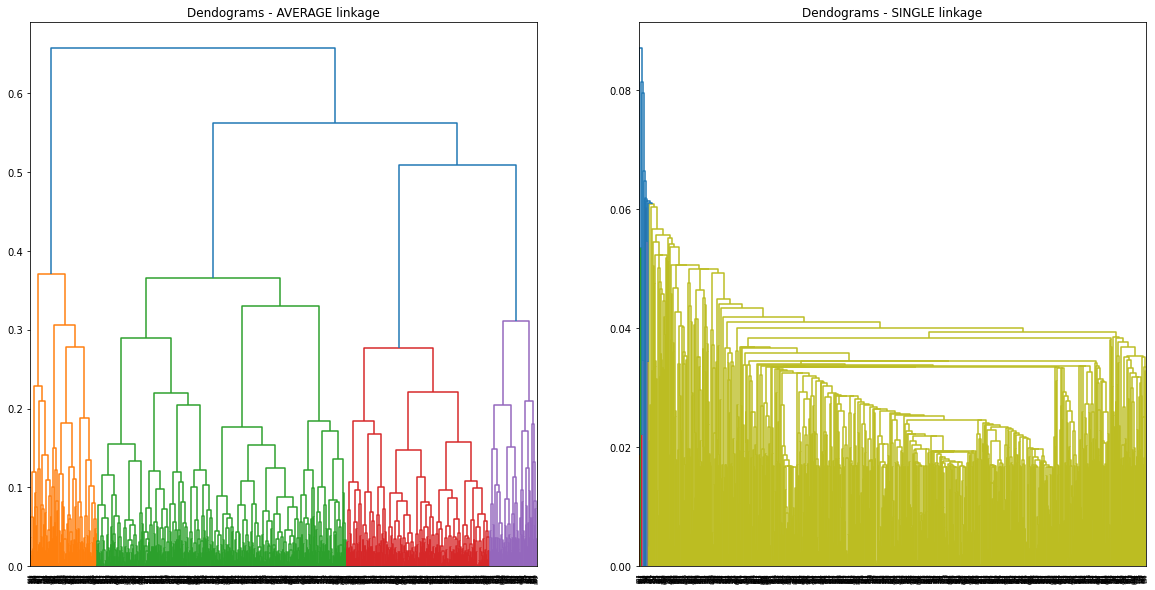

In [88]:
plt.figure(figsize = (20, 10))

plt.subplot(1,2,1)
plt.title("Dendograms - AVERAGE linkage")
linkage = hierarchy.linkage(data_norm[['rating_norm', 'total_norm']], method = 'average')
dendrogram = hierarchy.dendrogram(linkage)

plt.subplot(1,2,2)
plt.title("Dendograms - SINGLE linkage")
linkage = hierarchy.linkage(data_norm[['rating_norm', 'total_norm']], method = 'single')
dendrogram = hierarchy.dendrogram(linkage)

plt.show()

In [89]:
from sklearn.cluster import AgglomerativeClustering
##------------------------------------------------------------------------------
## Chọn k dựa trên biểu đồ scatter plot
##------------------------------------------------------------------------------
k = 3
hac = AgglomerativeClustering(n_clusters = k, affinity = 'euclidean', linkage = 'ward') 
hac.fit(data_norm[['rating_norm', 'total_norm']])
## Các clusters
labels     = hac.labels_
clustering_ward = pd.concat([data_norm, pd.Series(labels, name = 'cluster')], axis = 1)
print('Số phần tử của mỗi cluster theo ward linkage:')
print(clustering_ward.cluster.value_counts())
print('---------------------------------------------')

hac = AgglomerativeClustering(n_clusters = k, affinity = 'euclidean', linkage = 'complete') 
hac.fit(data_norm[['rating_norm', 'total_norm']])
## Các clusters
labels     = hac.labels_
clustering_complete = pd.concat([data_norm, pd.Series(labels, name = 'cluster')], axis = 1)
print('Số phần tử của mỗi cluster theo complete linkage:')
print(clustering_complete.cluster.value_counts())
print('---------------------------------------------')

hac = AgglomerativeClustering(n_clusters = k, affinity = 'euclidean', linkage = 'average') 
hac.fit(data_norm[['rating_norm', 'total_norm']])
## Các clusters
labels     = hac.labels_
clustering_average = pd.concat([data_norm, pd.Series(labels, name = 'cluster')], axis = 1)
print('Số phần tử của mỗi cluster theo average linkage:')
print(clustering_average.cluster.value_counts())
print('---------------------------------------------')

hac = AgglomerativeClustering(n_clusters = k, affinity = 'euclidean', linkage = 'single') 
hac.fit(data_norm[['rating_norm', 'total_norm']])
## Các clusters
labels     = hac.labels_
clustering_single = pd.concat([data_norm, pd.Series(labels, name = 'cluster')], axis = 1)
print('Số phần tử của mỗi cluster theo single linkage:')
print(clustering_single.cluster.value_counts())

Số phần tử của mỗi cluster theo ward linkage:
1    451
0    409
2    131
Name: cluster, dtype: int64
---------------------------------------------
Số phần tử của mỗi cluster theo complete linkage:
0    701
1    157
2    133
Name: cluster, dtype: int64
---------------------------------------------
Số phần tử của mỗi cluster theo average linkage:
2    488
0    373
1    130
Name: cluster, dtype: int64
---------------------------------------------
Số phần tử của mỗi cluster theo single linkage:
0    986
1      3
2      2
Name: cluster, dtype: int64


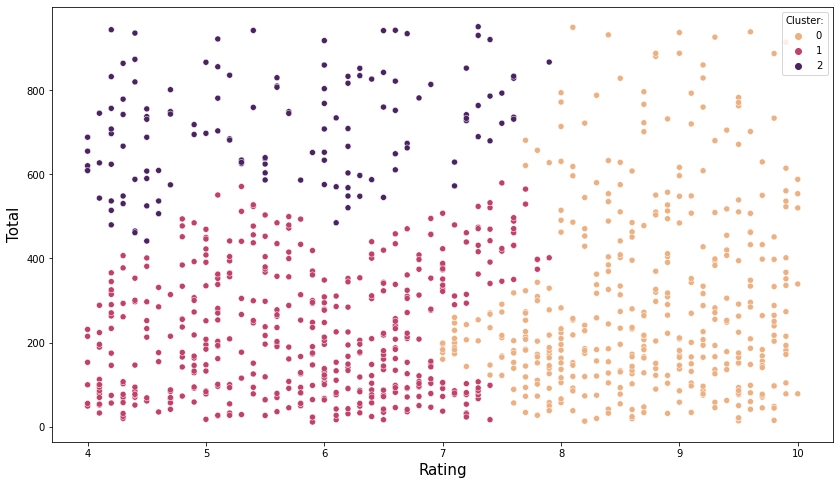

In [90]:
#vì phân cụm theo ward linkage cho ra 3 cụm tốt hơn so với các phương pháp còn lại nên ta chọn ward linkage
##------------------------------------------------------------------------------
## Biểu diễn kết quả gom cụm
##------------------------------------------------------------------------------
plt.figure(figsize = (14, 8))
sns.scatterplot(data = clustering_ward, x = 'Rating', y = 'Total', hue = 'cluster', palette = 'flare')
plt.xlabel('Rating', fontsize = 15)
plt.ylabel('Total', fontsize = 15)
plt.legend(title = 'Cluster:', loc = 1)
plt.show()

# **Kiểm định Chi_squared**

In [91]:
import scipy.stats 
scipy.stats.chisquare(data_sales["Gender"].value_counts())

Power_divergenceResult(statistic=0.004, pvalue=0.9495709711511051)

In [92]:
scipy.stats.chisquare(data_sales["Product line"].value_counts())

Power_divergenceResult(statistic=2.72, pvalue=0.7430578678524614)

In [93]:
# H0 : Giới tính và dòng sản phẩm là ĐỘC LẬP
# Ha : Giới tính và dòng sản phẩm là PHỤ THUỘC

In [94]:
cont = pd.crosstab(data_sales["Gender"],data_sales["Product line"])

In [95]:
scipy.stats.chi2_contingency(cont)

Chi2ContingencyResult(statistic=5.7444558595826445, pvalue=0.33188385805539106, dof=5, expected_freq=array([[85.17 , 89.178, 87.174, 76.152, 80.16 , 83.166],
       [84.83 , 88.822, 86.826, 75.848, 79.84 , 82.834]]))

In [96]:
alpha            = .05
confidence_level = (1 - alpha)

In [97]:
from scipy.stats import chi2_contingency
stat, p, dof, expected = chi2_contingency(cont)

In [98]:
print(f'Trị số p = {p:.2f}, alpha = {alpha:.2f}')

if (p < alpha):
    print('Vì (p < alpha) cho nên BÁC BỎ H0 ==> Có sự PHỤ THUỘC giữa giới tính và dòng sản phẩm')
else:
    print('Vì (p >= alpha) cho nên KHÔNG bác bỏ H0 ==> Giới tính và dòng sản phẩm là ĐỘC LẬP')    

Trị số p = 0.33, alpha = 0.05
Vì (p >= alpha) cho nên KHÔNG bác bỏ H0 ==> Giới tính và dòng sản phẩm là ĐỘC LẬP


# **Kiểm định ANOVA**

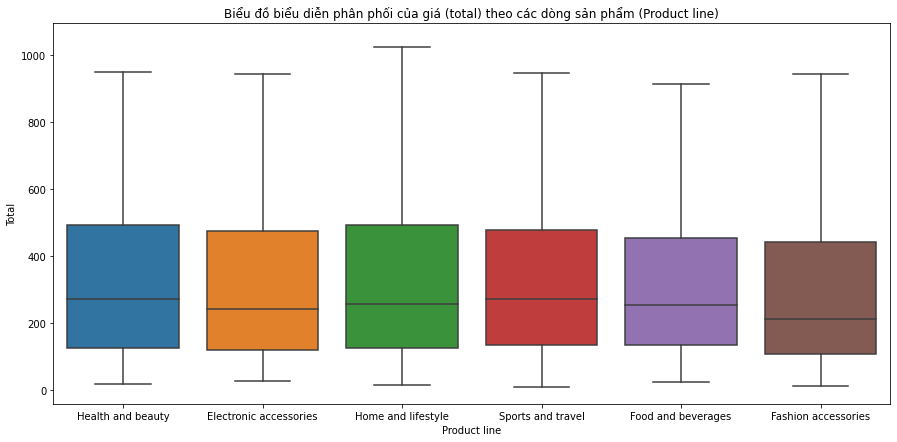

In [99]:
fig, ax = plt.subplots(figsize=(15, 7))
sns.boxplot(data = data_sales, x = 'Product line', y = 'Total', fliersize = 0 )
ax.set(title = "Biểu đồ biểu diễn phân phối của giá (total) theo các dòng sản phẩm (Product line)",
       xlabel = "Product line",
       ylabel = "Total")
plt.show()

In [100]:
alpha = 0.05

In [101]:
HB = data_sales[data_sales['Product line'] == "Health and beauty"]["Total"]
EA = data_sales[data_sales['Product line'] == "Electronic accessories"]["Total"]
HL = data_sales[data_sales['Product line'] == "Home and lifestyle"]["Total"]
ST = data_sales[data_sales['Product line'] == "Sports and travel"]["Total"]
FB = data_sales[data_sales['Product line'] == "Food and beverages"]["Total"]
FA = data_sales[data_sales['Product line'] == "Fashion accessories"]["Total"]

from scipy.stats import f_oneway
f, p = stats.f_oneway(HB, EA, HL, ST, FB, FA)
print(f'* Trị số p = {p:.2f}, alpha = {alpha:.2f}')

print("Ho: Không có sự khác biệt về giá giữa các dòng sản phẩm")
print("Ha: Có sự khác biệt về giá giữa các dòng sản phẩm\n")

# alpha = 0.05
if p < alpha:
  print("Trị số p < alpha cho nên bác bỏ H0 => Có sự khác biệt về giá giữa các dòng sản phẩm")
else:
  print("KHÔNG bác bỏ H0 ==> Không có sự khác biệt về giá giữa các dòng sản phẩm")

* Trị số p = 0.89, alpha = 0.05
Ho: Không có sự khác biệt về giá giữa các dòng sản phẩm
Ha: Có sự khác biệt về giá giữa các dòng sản phẩm

KHÔNG bác bỏ H0 ==> Không có sự khác biệt về giá giữa các dòng sản phẩm


# **PCA (với Data sử dụng là Data sau khi áp dụng mô hình RFM và chọn TARGET là Customer Type)**

In [102]:
#data dùng để thực hiện pca
dfc_copy.head()

,Recency,Frequency,Monetary,score,Customer Type
0,9,5,1648.9830,10,Khách hàng tiềm năng
1,32,7,3082.5375,10,Khách hàng tiềm năng
2,26,6,2060.1840,10,Khách hàng tiềm năng
3,11,5,1145.8860,9,Khách hàng tiềm năng
4,4,7,2522.9925,14,Khách hàng V.I.P


In [103]:
#vì range của cột Monetary chênh lệch với các cột còn lại lớn nên ta sẽ scale nó rồi tiến hành PCA
tg = pd.DataFrame(dfc_copy['Customer Type'])
dfc_copy.drop(columns = 'Customer Type', inplace = True)
scaler = StandardScaler()
scaler.fit(dfc_copy)

data = scaler.transform(dfc_copy)

data = pd.DataFrame(data)
data['Customer Type'] = tg['Customer Type']
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199 entries, 0 to 198
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   0              199 non-null    float64
 1   1              199 non-null    float64
 2   2              199 non-null    float64
 3   3              199 non-null    float64
 4   Customer Type  199 non-null    object 
dtypes: float64(4), object(1)
memory usage: 7.9+ KB


In [104]:
#đặt lại tên columns
data.rename(columns = {0: 'Recency', 1: 'Frequency', 2: 'Monetary', 3: 'Score'}, inplace = True)

In [105]:
#Tổng quan về dữ liệu sau khi scale để thực hiện giảm chiều (theo PCA)
from sklearn.decomposition import PCA
data.head()

,Recency,Frequency,Monetary,Score,Customer Type
0,-0.579016,-0.011796,0.029715,0.275596,Khách hàng tiềm năng
1,0.894111,0.927155,1.665929,0.275596,Khách hàng tiềm năng
2,0.509817,0.457680,0.499047,0.275596,Khách hàng tiềm năng
3,-0.450918,-0.011796,-0.544504,-0.016125,Khách hàng tiềm năng
4,-0.899261,0.927155,1.027282,1.442480,Khách hàng V.I.P


In [106]:
#mô tả tổng quan bộ dữ liệu data
target = 'Customer Type'
print('* Biến phân lớp:', target)

nb_features = data.shape[1] - 1
features    = data.columns[:nb_features]
print('* Số lượng features = %2d' %nb_features)
print('  Các features:', ', '.join(features)) 

* Biến phân lớp: Customer Type
* Số lượng features =  4
  Các features: Recency, Frequency, Monetary, Score


In [107]:
## Loại bỏ cột customer type trong dataframe
x = data.drop(columns = ['Customer Type'])
CT = pd.DataFrame(data['Customer Type'])

In [108]:
##giữ lại tối thiểu 90%
threshold = .90
percent   = threshold * 100

## Áp dụng PCA
pca = PCA(threshold)
pca.fit_transform(x) 

## Giá trị k thu được, với phương sai tích lũy tương ứng
k   = pca.n_components_
var = sum(pca.explained_variance_ratio_) * 100
print('   * Muốn phương sai tích lũy >= %.1f%%' %percent, 'thì k >= %d' %k, '--> %.1f%%' %var)

   * Muốn phương sai tích lũy >= 90.0% thì k >= 2 --> 93.4%


In [109]:
## Kiểm chứng: Phân tích chi tiết theo các ngưỡng phương sai từ 50% đến 99%
A = np.array([.5, .6, .7, .8, .9, .95, .99])
for t in A:
    percent = t * 100
    pca     = PCA(t)

    pca.fit(x)
    k   = pca.n_components_
    var = sum(pca.explained_variance_ratio_) * 100
    print('- Muốn phương sai tích lũy >= %.1f%%' %percent, 'thì k >= %2d' %k,  '(var ~ %.1f%%)' %var)

- Muốn phương sai tích lũy >= 50.0% thì k >=  1 (var ~ 74.9%)
- Muốn phương sai tích lũy >= 60.0% thì k >=  1 (var ~ 74.9%)
- Muốn phương sai tích lũy >= 70.0% thì k >=  1 (var ~ 74.9%)
- Muốn phương sai tích lũy >= 80.0% thì k >=  2 (var ~ 93.4%)
- Muốn phương sai tích lũy >= 90.0% thì k >=  2 (var ~ 93.4%)
- Muốn phương sai tích lũy >= 95.0% thì k >=  3 (var ~ 98.3%)
- Muốn phương sai tích lũy >= 99.0% thì k >=  4 (var ~ 100.0%)


In [110]:
## Áp dụng PCA với k = 2

pca = PCA(n_components=2)
pca.fit(x)

## Phép chiếu dữ liệu vào không gian mới
B = pca.transform(x)
B[0:5]

array([[ 0.39066444, -0.49547569],
       [ 1.12811623,  1.74899436],
       [ 0.44700349,  0.76207565],
       [-0.11109133, -0.6380842 ],
       [ 2.16848693, -0.13632828]])

In [111]:
## Gán column names cho các cột
df_pca = pd.DataFrame(B, columns = ['PC 1', 'PC 2'])
df_pca.head()

,PC 1,PC 2
0,0.390664,-0.495476
1,1.128116,1.748994
2,0.447003,0.762076
3,-0.111091,-0.638084
4,2.168487,-0.136328


In [112]:
df_pca['Customer Type'] = CT['Customer Type']
df_pca.head()

,PC 1,PC 2,Customer Type
0,0.390664,-0.495476,Khách hàng tiềm năng
1,1.128116,1.748994,Khách hàng tiềm năng
2,0.447003,0.762076,Khách hàng tiềm năng
3,-0.111091,-0.638084,Khách hàng tiềm năng
4,2.168487,-0.136328,Khách hàng V.I.P


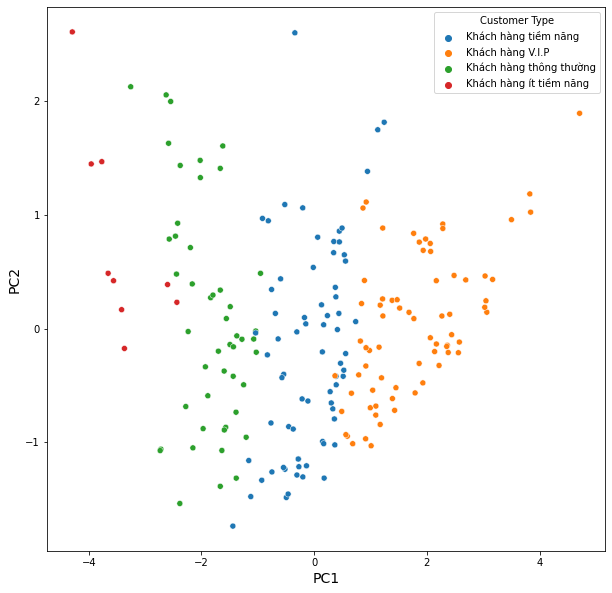

In [113]:
## Biểu diễn trực quan dữ liệu sau khi áp dụng PCA
plt.figure(figsize = (10, 10))
sns.scatterplot(x = "PC 1", y = "PC 2", data = df_pca, hue = 'Customer Type')
plt.xlabel('PC1', fontsize = 14)
plt.ylabel('PC2', fontsize = 14)
plt.show()